# Transformers 模型量化技术：GPTQ

![image](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/159_autogptq_transformers/thumbnail.jpg)

2022年，Frantar等人发表了论文 [GPTQ：Accurate Post-Training Quantization for Generative Pre-trained Transformers](https://arxiv.org/abs/2210.17323)。

这篇论文详细介绍了一种训练后量化算法，适用于所有通用的预训练 Transformer模型，同时只有微小的性能下降。

GPTQ算法需要通过对量化模型进行推理来校准模型的量化权重。详细的量化算法在[原始论文](https://arxiv.org/pdf/2210.17323.pdf)中有描述。

基于[`auto-gptq`](https://github.com/PanQiWei/AutoGPTQ.git) 开源实现库，transformers 支持使用GPTQ算法量化的模型。

## 使用 GPTQ 量化模型

为了使用 `auto-gptq` 库量化一个模型，我们需要向量化器传递一个数据集。

通常有两种方式构造数据集：
- 量化器支持的默认数据集（包括`['wikitext2','c4','c4-new','ptb','ptb-new']`）
- 一个字符串列表（这些字符串将被用作数据集）

### 使用 GPTQ 算法支持的默认数据集来量化

在下面的示例中，让我们尝试使用`"wikitext2"`数据集将模型量化为4位精度。支持的精度有`[2, 4, 6, 8]`。

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig
import torch

model_name_or_path = "facebook/opt-2.7b"

quantization_config = GPTQConfig(
     bits=4, # 量化精度
     group_size=128,
     dataset="wikitext2",
     desc_act=False,
)

#### 逐层量化

关于 `CUDA extension not installed` 的说明: https://github.com/AutoGPTQ/AutoGPTQ/issues/249

***尝试：重新安装auto_gptq包，安装前设置环境变量BUILD_CUDA_EXT=1***
```sh
export BUILD_CUDA_EXT=1
pip install -U auto_gptq
```

In [4]:
quant_model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    quantization_config=quantization_config,
    device_map='auto')

Quantizing model.decoder.layers blocks : 100%|██████████| 32/32 [29:01<00:00, 54.42s/it]


### 实测 GPTQ 量化模型：GPU显存占用峰值超过10GB

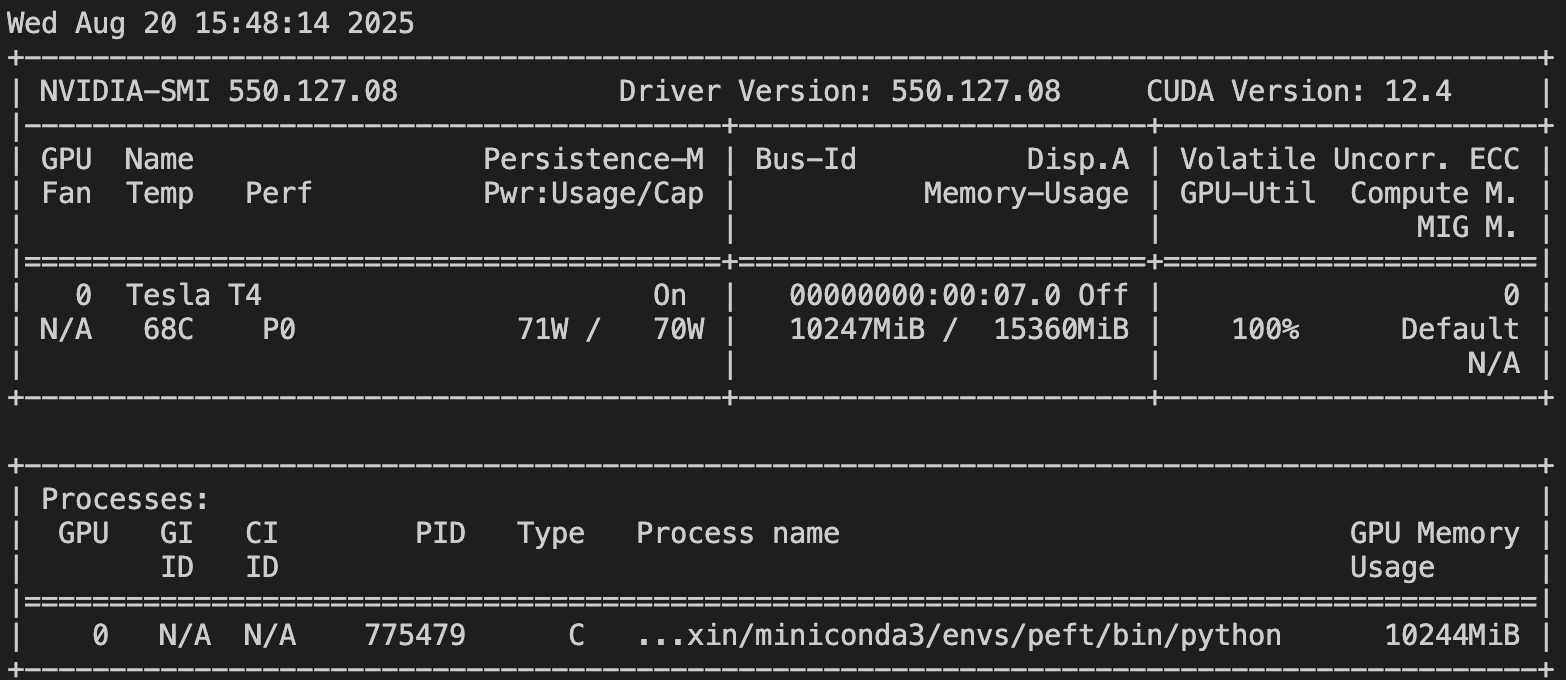

### 检查量化模型正确性

通过检查`线性层的属性`来确保模型已正确量化，它们应该包含`qweight`和`qzeros`属性，这些属性应该是`torch.int32`数据类型。

In [5]:
quant_model.model.decoder.layers[0].self_attn.q_proj.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict([('qweight',
               tensor([[ 1766754698, -1249142373,  1183631034,  ..., -2038658921,
                        -2037544795, -1956877206],
                       [ 1772710025,  1739893370, -1500087466,  ...,  2021033895,
                         -662329995,  1756019066],
                       [ -895658394, -2007414633, -1951893913,  ..., -1429760649,
                         -980833883,  1451914633],
                       ...,
                       [ 2025363833, -1412855115,  1539086490,  ...,  -342189415,
                        -1737062521, -1950833303],
                       [ 2023326856, -1432974698, -1788251003,  ..., -1161734024,
                         2043176297,  1449571741],
                       [ 1769506966, -2021291654, -1182103157,  ...,  1999993942,
                         1753778600,  1970816134]], device='cuda:0', dtype=torch.int32)),
              ('qzeros',
               tensor(

In [6]:
# 保存模型权重
quant_model.save_pretrained("models/opt-2.7b-gptq")

#### 模型保存内容：

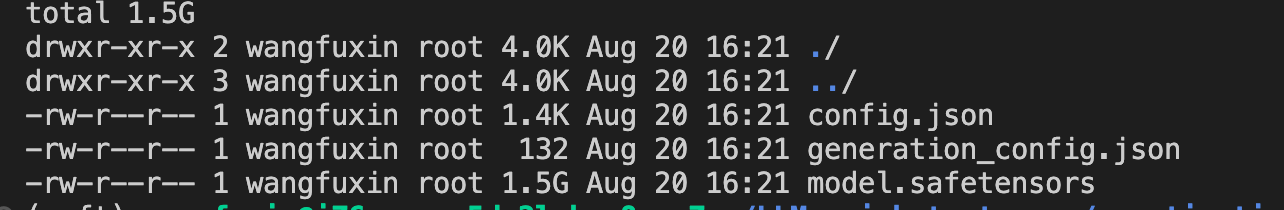

#### 使用 GPU 加载模型并生成文本

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

text = "Merry Christmas! I'm glad to"
inputs = tokenizer(text, return_tensors="pt").to(0)

out = quant_model.generate(**inputs, max_new_tokens=64)
print(tokenizer.decode(out[0], skip_special_tokens=True))

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Merry Christmas! I'm glad to see you're still around.
Thanks! I'm still here, just not posting as much.


### 使用自定义数据集量化模型（灵活可扩展，前提是准备好数据）

下面演示通过传递自定义数据集来量化一个模型。

通过字符串列表来自定义一个数据集，建议样本数不少于128（样本数太少会影响模型性能）

In [8]:
from transformers import AutoModelForCausalLM, GPTQConfig, AutoTokenizer

model_name_or_path = "facebook/opt-2.7b"
custom_dataset = ["auto-gptq is an easy-to-use model quantization library with user-friendly apis, based on GPTQ algorithm."]

custom_quantization_config = GPTQConfig(
    bits=4,
    group_size=128,
    desc_act=False,
    dataset=custom_dataset
)

custom_quant_model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                                          quantization_config=custom_quantization_config,
                                                          torch_dtype=torch.float16,
                                                          device_map="auto")

Quantizing model.decoder.layers blocks : 100%|██████████| 32/32 [06:17<00:00, 11.79s/it]


***量化过程的GPU使用：***

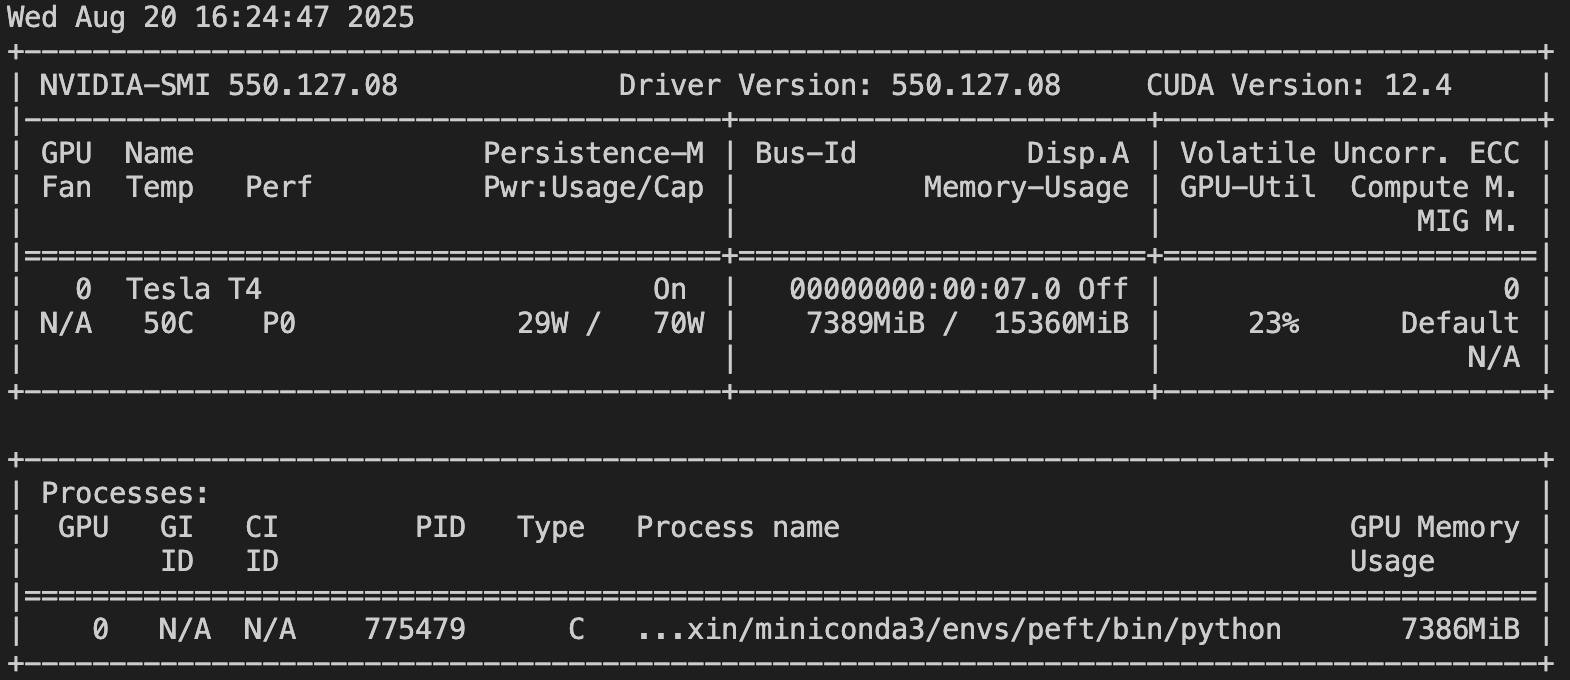

***耗时大幅减少。***

相比使用默认数据集，未经精心准备的自定义数据集会明显降低模型性能

In [9]:
text = "Merry Christmas! I'm glad to"
inputs = tokenizer(text, return_tensors="pt").to(0)

out = custom_quant_model.generate(**inputs, max_new_tokens=64)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Merry Christmas! I'm glad to.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.



## [Optional]Homework: 使用 GPTQ 算法量化 OPT-6.7B 模型


首次运行发现报告`CUDA Extension not installed` ，量化过程也正常执行，但耗时非常久之后，也没有进展。

查阅指导文档后，通过重新安装`auto_gptq`包，正确调用了GPU算力资源
#### 量化过程
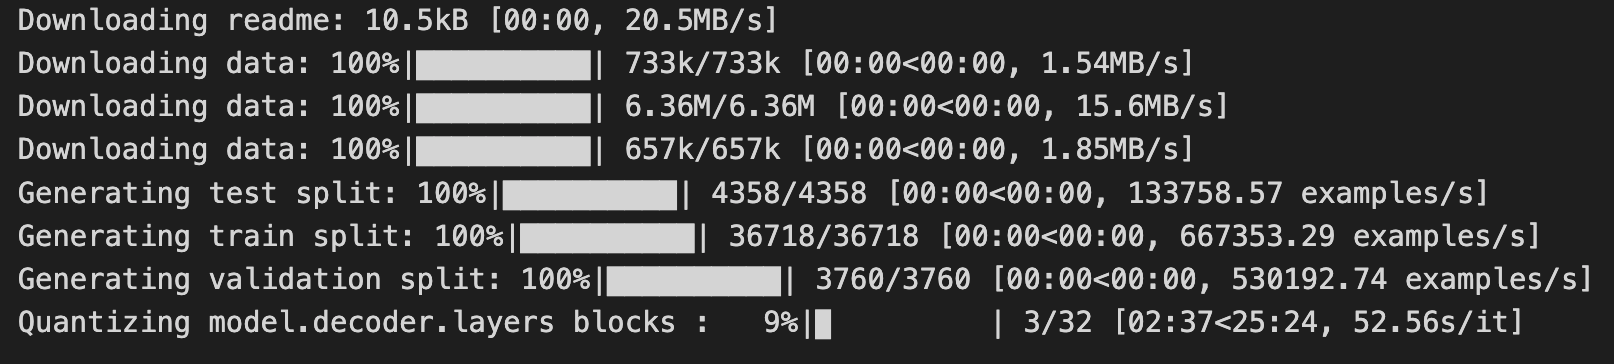

#### GPU使用情况
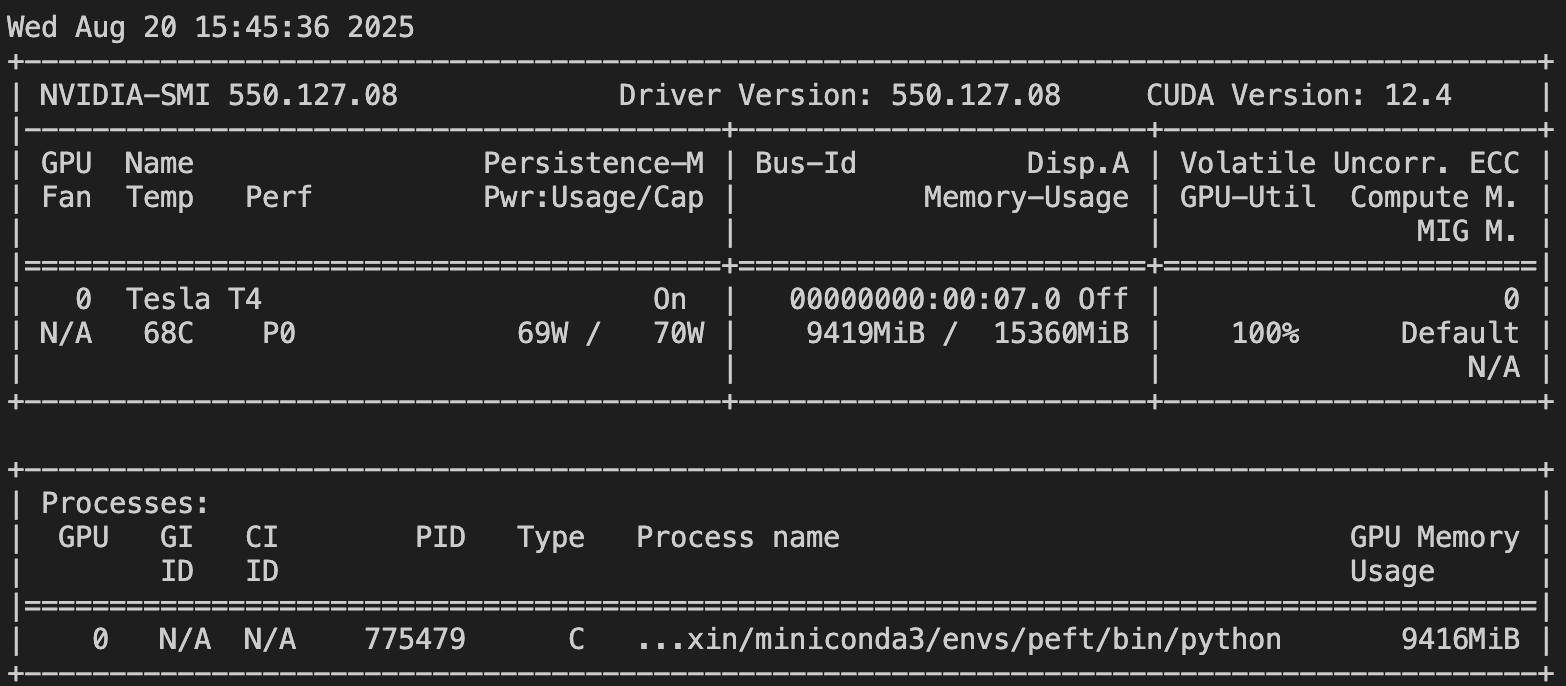

#### 自定义数据集用于量化

由于语料过于简单，量化过程较快（10分钟内完成），量化后的模型（内存中）效果很差，对比使用标准数据集量化结果，其无法给出预期答复。